# Homework I - Metodi quantitativi per la gestione del rischio
## Simona Maria Borrello s277789 
## Giulio Cerruto s277335 <a class="tocSkip">

## Introduzione
L'obiettivo dell'eleborato è quello di valutare e confrontare, in diversi scenari, differenti strategie di Hedging che fanno uso di due tipi di derivati: Features e Options. \\
Come è noto, lo scopo dell' Hedging è quello di ridurre il rischio, che nel nostro caso , è legato a due diversi fattori: l'*exchange rate* Dollaro/Euro e il numero di studenti che si realizza. \\
Il lavoro  si articola in 3 parti: 
* la prima parte vede come obiettivo l'implementazione, la descrizione e un utilizzo esemplificativo di 3 classi distinte:  *ScenarioComparer*, *DecisionComparer* e *ScenarioGenerator*;

* la seconda parte è, invece, dedicata all'utilizzo degli strumenti appena creati al fine di eseguire una analisi di possibili decisioni tramite l'utilizzo di misure di rischio.

* la terza parte è incentrata su un'analisi di sensitività delle decisioni ottime rispetto allo strike exchange rate e al numero di studenti che il decisore si aspetta.

In [1]:
import numpy as np
from scipy.stats import norm
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import scipy.special as sps
! pip install reliability
! yes | python -m pip uninstall matplotlib
! pip install matplotlib==3.1.3
from reliability.Distributions import Gamma_Distribution
import matplotlib.pyplot as plt
np.random.seed(seed=2021) # settiamo il random seed

     |████████████████████████████████| 222 kB 5.0 MB/s 
     |████████████████████████████████| 86 kB 4.9 MB/s 
     |████████████████████████████████| 10.3 MB 37.7 MB/s 
     |████████████████████████████████| 28.5 MB 29 kB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=9240af0639837561a4e413632f6318a820073fd496bca932acd440ab12435a52
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
  Created wheel for mplcursors: filename=mplcursors-0.4-py3-none-any.whl size=19983 sha256=ec98f040152ee14f70906e047296fda3119f4f4723bfa8d13c11bc1fa70dd8ea
  Stored in directory: /root/.cache/pip/wheels/09/8a/90/32b30a664f7c3c4b0062f2cc5593696d1d82e758dc54d5cc1f
Successfully built autograd-gamma mplcursors
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: matplotlib
    Foun

Found existing installation: matplotlib 3.4.2
Uninstalling matplotlib-3.4.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.4.2-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.4.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)?   Successfully uninstalled matplotlib-3.4.2
     |████████████████████████████████| 13.1 MB 90 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
reliability 0.6.0 requir

## I PARTE: Implementazione degli strumenti
La strategia di Hedging rappresenta la  **decisione** da prendere. \\
 Essa, nell'eleborato, è  identificata da un vettore bidimensionale, le cui componenti corrispondono, rispettivamente, alla **percentuale di contratti Forwards e Options stipulati**. \\
Suddetta percentuale è calcolata rispetto al totale dei costi che i decisori si aspettano di dover affrontare al termine della maturità. Vedremo come calcolare una tale quantità nel seguito.   \\
 E' possibile anche che una parte dei costi **non venga coperta** in alcun modo. In tal caso, la percentuale  *%Nohedge* sarà semplicemente  1- *%Hedge*= 1- *%Forwards - %Options*. 

Prima di  entrare nel vivo dell'analisi, è  opportuno fare alcune precisazioni generali:
* la **valutazione** delle decisioni è stata effettuata in termini di **profitti**, per cui si è ritenuto necessario assumere un prezzo unitario che lo studente è tenuto a pagare.  
*  **il prezzo delle opzioni** è calcolato sulla base del modello di **Black-Scholes-Merton**. Per prezzare le  *currency call options*, si fissa $S_0$, lo *spot exchange rate* al tempo di sottoscrizione dei contratti, a 1.22 (per ulteriori approfondimenti, fare riferimento al paragrafo 17.5 di 'Options, Futures and other Derivatives, John C.Hull, Edizione n°9). 
- i valori di default utilizzati sono giustificati dai dati storici dei Bund tedeschi a 1 anno e dei Trasury bonds a 1 anno.


Per esemplificare il calcolo dei profitti, riportiamo le seguenti osservazioni: 
* il profitto varia in base alle seguenti variabili:
  * lo Spot exchange rate che si realizza alla maturità $T$ $S_T$;
  * il numero di studenti che si realizza $N$;
  * il numero di studenti che il decisore si aspetta arrivino $ES$;
  * la strategia di hedging $\%FW, \%OPT, \%NH$;
  * lo Strike exchange rate $K$;
  * il prezzo che ogni studente è tenuto a pagare $p$;
  * il costo che bisogna sostenere per ogni studente $c$;
  * il prezzo di un'opzione $o$;
* nel caso in cui vengano sottoscritti dei contratti forward per una quantità di denaro maggiore di quella effettivamente necessaria, la valuta in eccesso può essere rivenduta nello Spot market;
* i profitti sono dati dalla differenza dei ricavi totali e i costi totali sostenuti.

I profitti sono quindi ottenuti tramite la seguente formula:
$$
\begin{align}
 Profit =\ &N\cdot p\ -\\
  \ &\{N \cdot K \cdot c\ +\\
  &(N - \%FW \cdot ES) \cdot max (K-S_T,0) \cdot c\ -\\
  \ & [N - (\%FW + \%OPT) \cdot ES ] \cdot max(S_T-K,0) \cdot c\ +\\
  \ & \%OPT \cdot ES \cdot o\}
\end{align}
$$
Nella prima riga sono calcolati i ricavi, nella seconda il costo totale di riferimento rispetto a cui vengono ulteriormente aggiunti i profitti o  sottratte le perdite risultanti dallo spot exchange rate che si realizza (in maniera analoga a quanto fatto durante le lezioni). Nello specifico: se $K>S_T$ (terza riga), viene acquistato sul mercato Spot tutto il denaro necessario che non sia coperto da contratti forward (non essendo conveniente esercitare le opzioni); mentre, se $K<S_T$ (quarta riga) tutto ciò che non è coperto da forward e opzioni rappresenta un costo in più rispetto alla situazione di riferimento.\
Inoltre, alla terza riga è contemplato il caso in cui la quantità di valuta acquistata tramite contratti forward risulti eccessiva rispetto a quella necessaria, con la possibilità di rivendere la parte in eccesso sul mercato Spot.\
Infine, all'ultima riga, è calcolato il prezzo totale delle opzioni sottoscritte.

Introduciamo la prima classe: *ScenarioComparer*.  

Come il nome suggerisce, essa vede come obiettivo finale  il confronto, al variare di tutte le decisioni, di diversi scenari. \\
L'unico parametro che è obbligatorio impostare per definire la classe è la lista degli **scenari** che si vuole **analizzare**. \\
Ai restanti parametri viene attribuito un valore di default, che naturalmente può essere specificato e scelto a proprio piacimento. \\
In particolare, se  nessuna lista di decisioni è predisposta, allora viene, di default, costruita una **griglia di decisioni** ( ottenuta tramite il prodotto cartesiano di due vettori di elementi equispaziati tra 0 e 1, tenendo conto del vincolo di ammissibilità per cui la somma degli elementi deve essere minore o uguale di 1). \\

Descriviamo  adesso  brevemente le **funzionalità** della classe. \\

Per ottenere tutti profitti, cioè i profitti per ogni decisione e ogni scenario, l'utente può utilizzare il metodo *get_profits*. \\
Essi, inoltre, possono essere plottati in 3D, fissato lo scenario, tramite *plot_scenarios*. Nel plot 3D, sull'asse *x* è collocata la *%Forward* , sull'asse *y* la *%Options* e sull'asse *z* il profitto. Lo scatterplot è caratterizzato dalle gradazioni di 3 colori: una scala di <font color= #FF000> **rosso**</font> nel caso di <font color= #FF000> **perdite** </font>, **bianco** nel caso di valori prossimi allo **zero** e <font color= #00FF00> **verde**</font> nel caso di <font color= #00FF00> **profitti** </font>. \\
Infine se si vogliono calcolare i profitti per un dato scenario e per tutte le decisioni, si può utilizzare *compute_single_profit*.   

In [2]:
class scenarioComparer:

  def __init__(self, scenarios : list, decisions : list = None , costPerStudent : float = 1000, pricePerStudent: float= 2000,
               strikeExRate : float = 1.22, spotExRate0 : float= 1.22, DomInterestRate : float = 0.04,
               ForInterestRate: float = -0.05,  maturity : float = 1, expectedStudents: int = 25000, volatility: float = 0.028):
    self.__scenarios = scenarios # [(spot exchange rate a T, volume)]
    self.__costPerStudent = costPerStudent
    self.__strikeExRate = strikeExRate
    self.__maturity = maturity
    self.__expectedStudents = expectedStudents
    self.__spotExRate0 = spotExRate0    
    self.__volatility = volatility
    self.__DomInterestRate = DomInterestRate
    self.__ForInterestRate = ForInterestRate
    self.__optionPrice = self.__pricing_call_option()
    self.__profitGrid = None
    self.__pricePerStudent = pricePerStudent
    
        
    if decisions is None:
      self.__fw_decisions = np.linspace(start=0, stop=1, num=16)
      self.__opt_decisions = np.linspace(start=0, stop=1, num=16)
      self.__decisions = np.dstack(np.meshgrid(self.__fw_decisions, self.__opt_decisions)).reshape(-1,2)
      mask= self.__decisions[:,0]+ self.__decisions[:,1] <= 1
      self.__decisions= self.__decisions[mask,:]

    else:
       self.__decisions= np.array(decisions)
       mask= self.__decisions[:,0]+ self.__decisions[:,1] <= 1
       self.__decisions= self.__decisions[mask,:]



  def __compute_profits(self): # calcola il costo totale per tutti gli scenari e per tutti i set di decisioni e li salva nell'array
    self.__profitGrid = []

    for scenario in self.__scenarios:
      scenario_grid = np.empty(len(self.__decisions))
      for idx, decision in enumerate(self.__decisions):
        scenario_grid[idx] = self.compute_single_profit(scenario[0], scenario[1], decision[0], decision[1])
       
      self.__profitGrid.append(scenario_grid)
      

  def compute_single_profit(self, spotExRate : float, studentN : int, FW : float, OPT : float): # calcola il costo totale dato un singolo scenario e un set di decisioni
    NH = 1 - FW - OPT
    
    return studentN * self.__pricePerStudent - (studentN * self.__strikeExRate * self.__costPerStudent - (studentN - FW * self.__expectedStudents) * max(self.__strikeExRate - spotExRate, 0) * self.__costPerStudent + (studentN - (FW + OPT) * self.__expectedStudents) * max(spotExRate - self.__strikeExRate, 0) * self.__costPerStudent + OPT * self.__expectedStudents * self.__optionPrice)


  def __pricing_call_option(self):
    # pag 377 dell hull
    d1 = (np.log(self.__spotExRate0 / self.__strikeExRate) + (self.__DomInterestRate - self.__ForInterestRate + self.__volatility**2 / 2) * self.__maturity) / (self.__volatility * np.sqrt(self.__maturity))
    d2 = d1 - self.__volatility * np.sqrt(self.__maturity)
    
    return self.__spotExRate0 * np.exp( - self.__ForInterestRate * self.__maturity) * norm.cdf(d1) - self.__strikeExRate * np.exp( - self.__DomInterestRate * self.__maturity) * norm.cdf(d2)


  def get_profits(self):
    self.__compute_profits()
    return self.__profitGrid

  
  def plot_scenarios(self):
    fig = go.Figure()

    for scenario in range(len(self.__scenarios)):
      fig.add_trace(go.Scatter3d(x=self.__decisions[:,0]*100, y=self.__decisions[:,1]*100, z=self.__profitGrid[scenario], mode='markers',visible=False, marker={"size": 5, "color": list(self.__profitGrid[scenario]), "cmid": 0, "colorscale": [(0,"darkred"),(0.25,'red'), (0.45,'lightcoral') , (0.5,'white') , (0.65, 'lightgreen'),(0.75, 'green'), (1,"darkgreen")]  }))

    fig.data[0].visible = True

    # Create and add slider
    steps = []
    for i in range(len(fig.data)):
        step = dict(
            method="update",
            args=[{"visible": [False] * len(fig.data)},
                  {"title": "Scenario n° " + str(i) +': Spot rate=' + '{:.2f}'.format(self.__scenarios[i][0])+ ', Numero di studenti= ' + str(self.__scenarios[i][1]),
                   "scene.xaxis.title" : '% FORWARD',
                   "scene.yaxis.title" : '% OPZIONI',
                   "scene.zaxis.title" : 'PROFITTO'}],  # layout attribute
        )
        step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
        steps.append(step)
    
    sliders = [dict(
        active=0,
        currentvalue={"prefix": "scenario: "},
        pad={"t": len(self.__scenarios)},
        steps=steps
    )]

    fig.update_layout(
        sliders=sliders,
    )
    
    fig.show()
    

Proviamo adesso ad utilizzare la classe con degli scenari esemplificativi. Passiamo quindi al costruttore della classe la lista di tuple rappresentante gli scenari da comparare. Gli scenari sono stati scelti in modo da condividere alcuni valori e permetterci, quindi, di dedurre alcune considerazioni. \
Per fare i conti con l'attualità, aggiungiamo uno scenario 'Covid-19', in cui il numero di studenti è stato azzerato dalla pandemia a partire dal terzo mese dell'anno.

In [3]:
scenarios = [(1.01,25000), (1.48,25000), (1.01,10000), (1.22,5000), (1.48,10000),
             (1.22,40000), (1.48,40000), (1.09, 5000), (1.9, 5000), (1.22,20), [0.54,10000]] # elenco di scenari da comparare
sc = scenarioComparer(scenarios=scenarios)
sc.get_profits()
sc.plot_scenarios()

**Considerazioni**: \\
* Le tuple di scenari (0,2),  (3, 5, 9), (1 ,4, 6) hanno **spot** exchange **rate uguale**. La "forma" dei profitti è identica all'interno della tupla e la differenza risiede nel range in cui variano i profitti a causa del diverso numero di studenti negli scenari in considerazione. Vediamo in dettaglio il motivo di tale fenomeno: 
  * in caso di **dollaro forte** rispetto allo strike exchange rate  (prima tupla di scenari):
    * all'aumentare della %forward, diminuisce il profitto;
    *  la %options lascia quasi inalterati i profitti (l'impatto dovuto al prezzo delle opzioni è pressochè ininfluente). 
  * in caso di **dollaro stabile** rispetto allo strike exchange rate (seconda tupla di scenari): 
      * al variare della %forward, il profitto resta inalterato;
      * all'aumentare della %options, il profitto diminuisce.
  * in caso di **dollaro debole** rispetto allo strike exchange rate (terza tupla di scenari):
   * all'aumentare della %forward, il profitto aumenta;
    * all'aumentare della %options, il profitto aumenta.

* Le tuple di scenari (0,1), (2,4), (3,7,8), (5,6) hanno il **numero di studenti** uguale. Tuttavia in questo caso,  non è immediato estrapolare un pattern grafico che accomuni tali tuple. E' possibile piuttosto individuare un intervallo numerico dei profitti simile. Infatti osserviamo che:
  * come ci si può effettivamente aspettare, all'aumentare del numero di studenti, corrisponde tendenzialmente un profitto maggiore;
  * meno evidente è, invece, un nesso tra l'ampiezza dell'intervallo in cui variano i profitti e la distanza dello spot exchange rate dallo strike rate. A titolo esemplificativo, consideriamo i seguenti casi:
    * nel caso in cui i due rate coincidano, la variabilità è ridotta al minimo (nello scenario 3 i profitti variano in un range ristretto: [3.87M, 3.9M]) 
    * a una differenza in valore assoluto tra i due rate relativamente grande, corrisponde un altrettanto ampia variabilità dei proffiti (nello scenario 8 la differenza tra i rate è pari a +0.68, mentre nello scenario 10 essa è pari a -0.68; in entrambi i casi l'ampiezza dell'intervallo è di circa 15M).
* Nello scenario 9 ('Covid-19'), possiamo notare come alcune decisioni possano portare a perdite. In particolare, sembra che le situazioni più critiche siano quelle in cui la %options è maggiore, a causa di un mancato bilanciamento del costo delle opzioni per mezzo di profitti.

La seconda classe che introduciamo è *ScenarioGenerator*. \\
Essa adempie alla creazione  di una lista di vettori, contenenti la **realizzazione** dei nostri **fattori di rischio**. \\
 Ogni vettore è quindi costuitito da due componenti: 
* la prima rappresenta lo ***Spot Exchange Rate*** , che è stato simulato a partire da una distribuzione normale. Il risultato è ottenuto applicando la formula contenuta nella *Proposizione 1* di http://galton.uchicago.edu/~lalley/Courses/390/Lecture9.pdf . 
* la seconda si riferisce al **numero di studenti** ed è ottenuta dal campionamento di una **distrubuzione Gamma**, che modelizza la domanda. I parametri di tale distribuzione possono essere scelti in fase di istanziamento dell'oggetto. Nel caso in cui non vengano specificati direttamente, quelli di default sono stati scelti in modo tale che il valore atteso sia pari a 25000 e che la distribuzione sia **asimettrica** (nel senso che alla coda di sinistra è associata una maggiore probabilità).  Si veda la figura sottostante.  Osserviamo inoltre che il numero di studenti così generato sarà  un numero non intero; tuttavia, tale caratteristica non rappresenta alcun problema, dato che i volumi in oggetto sono relativamente alti. 


Plottiamo innanzitutto la distribuzione reale del numero di studenti.

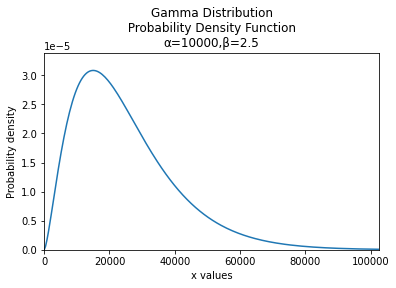

In [4]:
scale= 10000
shape= 1/10000 * 25000 
dist = Gamma_Distribution(alpha=scale, beta=shape)  # this created the distribution object
dist.PDF()  # this creates the plot of the PDF
plt.rcParams["figure.figsize"] = (13,4)

plt.show()

E' inoltre possibile, tramite il metodo 'plot', ottenere uno scatter plot degli scenari generati.


Infine, è possibile ricavare una sorta di valore atteso *stimato* (che viene salvato nell'attributo pubblico  *ExpectedStudentEstimate*), nell'ipotesi in cui i decisori non conoscano con esattezza i parametri della distribuzione della domanda. \\
 Di conseguenza,  **il numero di studenti attesi** può **non coincidere con il valore atteso** della distribuzione. \\
 Per tenere conto di ciò, la stima che i decisori fanno viene calcolata tramite l'aggiunta  di due errori ai parametri della distribuzione della domanda. 
 Supponiamo che tali **errori** siano **normalmente distribuiti** con media nulla e varianza proporzionale ai parametri della distribuzione Gamma. \\
L'assunzione implicita dietro a tale scelta è la seguente: ipotizziamo che i **decisori conoscano** con esattezza la **famiglia di distribuzione** della domanda, mentre ne **ignorano** i  **parametri** veri. 

In [5]:
class ScenarioGenerator:
  def __init__(self, spotExRate0: float=1.22, DomInterestRate: float=0.04, ForInterestRate: float=0.05, volatility: float= 0.028, maturity: float=1, shape: float=shape , scale: float=scale ):
    self.__spotExRate0= spotExRate0
    self.__DomInterestRate= DomInterestRate
    self.__ForInterestRate = ForInterestRate
    self.__maturity= maturity
    self.__shape= shape
    self.__scale= scale
    self.__volatility= volatility
    self.ExpectedStudentEstimate = (self.__shape + np.random.normal(0, (self.__shape)**(1/32), 1)[0]) * (self.__scale + np.random.normal(0, (self.__scale)**(1/32), 1)[0])
    self.scenarios=[]

  def generate_scenarios(self, N: int=1):
    
    for i in range(N):
      self.scenarios.append(( self.__Nstudents_realization(), self.__spotExRate_realization() ))
    return self.scenarios
  def plot(self):
    scenarios= np.array(self.scenarios)
    fig= go.Figure(go.Scatter(x= scenarios[:,0], y= scenarios[:,1], mode= 'markers' ))
    fig.update_layout(  xaxis_title='Numero di studenti', yaxis_title= 'Spot Exchange Rate')
    fig.show()

  def __pricing_call_option(self):
    # pag 377 dell hull
    d1 = (np.log(self.__spotExRate0 / self.__strikeExRate) + (self.__DomInterestRate - self.__ForInterestRate + self.__volatility**2 / 2) * self.__maturity) / (self.__volatility * np.sqrt(self.__maturity))
    d2 = d1 - self.__volatility * np.sqrt(self.__maturity)
    
    return self.__spotExRate0 * np.exp( - self.__ForInterestRate * self.__maturity) * norm.cdf(d1) - self.__strikeExRate * np.exp( - self.__DomInterestRate * self.__maturity) * norm.cdf(d2)

  def __spotExRate_realization(self):
    #http: // galton.uchicago.edu / ~lalley / Courses / 390 / Lecture9.pdf
    eps= np.random.normal(0, (self.__maturity)**(1/2), 1)[0]
    return self.__spotExRate0 * np.exp( (self.__DomInterestRate- self.__ForInterestRate)* self.__maturity- (self.__volatility)**2 * self.__maturity/2 + (self.__volatility) * eps )

  def __Nstudents_realization(self):
    return np.random.gamma(self.__shape, self.__scale, 1)[0]

L'ultima e **terza classe** che presentiamo è *decisionComparer*, che si contrappone, in qualche senso, a *scenarioComparer*.  

Tale classe ha come scopo il confronto delle decisioni, sulla base dei profitti, in tutti gli scenari.  

L'unico parametro che è obbligatorio impostare per definire la classe è la lista delle **decisioni** che si vuole **analizzare**. \\
Ai restanti parametri viene attribuito un valore di default, che naturalmente può essere specificato e scelto a proprio piacimento. \\
In particolare, se  nessuna lista di scenari è predisposta, allora viene, di default, costruita una **griglia di scenari** (ottenuta tramite il prodotto cartesiano di due vettori di elementi equispaziati negli intervalli di [0, 50000] e [0.9, 1.6], rispettivamente per il numero di studenti e il rate). \\

Oltre le funzionalità già descritte per la prima classe  e del tutto affini, *decisionComparer* contiene  3 ulteriori metodi, che fanno riferimento al calcolo di **misure di rischio**. Essi sono: 

* *compute_var*: stima il **Value at Risk** (livello di default $ \alpha= 0.05$ e orizzonte temporale $T$) per tutte le decisioni, usando la distribuzione empirica (cioè quella ottenuta con la lista di scenari della classe) dei **profitti**. Inoltre, restituisce la **decisione ottima** (ottenuta massimizzando il V@R). 
E' possibile anche ottenere l'istogramma dei profitti nella decisione ottima (*showplot = True*). Osserviamo che il problema di ottimizzazione andrebbe di regola formulato come minimizzazione di una misura di rischio; nel nostro caso, però, essendo la coda da penalizzare quella di sinistra (trattandosi di profitti e non di perdite), la misura di rischio va massimizzata, piuttosto che minimizzata.
* *compute_cvar*: stima il **Conditional Value at Risk** (livello di default $ \alpha= 0.05$ e orizzonte temporale $T$), sfruttando *compute_var*. Le struttura di tale metodo è analoga a quello precedente. 
* *compute_std*: stima la **Deviazione standard** dei profitti per tutte le decisioni. Inoltre, restituisce la **decisione ottima** (ottenuta minimizzando la deviazione standard).
* *compute_semivariance*: stima la **Semivarianza** dei profitti per tutte le decisioni. Inoltre, restituisce la **decisione ottima** (ottenuta minimizzando la semivarianza).




In [6]:
 class decisionComparer:

  def __init__(self, decisions : list, scenarios : list = None, costPerStudent : float = 1000, pricePerStudent: float= 2000,
               strikeExRate : float = 1.22, spotExRate0 : float= 1.22, DomInterestRate : float = 0.04,
               ForInterestRate: float = -0.05,  maturity : float = 1, expectedStudents: int = 25000, volatility : float = 0.028):
    
    self.__decisions= np.array(decisions)
    mask= self.__decisions[:,0]+ self.__decisions[:,1] <= 1
    self.__decisions= self.__decisions[mask,:]

    self.__costPerStudent = costPerStudent
    self.__strikeExRate = strikeExRate
    self.__maturity = maturity
    self.__expectedStudents = expectedStudents
    self.__spotExRate0 = spotExRate0    
    self.__volatility = volatility
    self.__DomInterestRate = DomInterestRate
    self.__ForInterestRate = ForInterestRate
    self.__optionPrice = self.__pricing_call_option()
    self.__profitGrid = None
    self.__pricePerStudent = pricePerStudent
    
    if scenarios is None: 
      self.__number_student = np.linspace(start=0, stop=50000, num=16)
      self.__rate_realization = np.linspace(start=0.9, stop=1.6, num=16)
      self.__scenarios = np.dstack(np.meshgrid(self.__number_student, self.__rate_realization)).reshape(-1,2)
      #print(self.__scenarios)
    else:
       self.__scenarios= np.array(scenarios)
       #self.__rate_realization = np.array(self.__scenarios)[:,0]
       #self.__number_student = np.array(self.__scenarios)[:,1]


  def __compute_profits(self): # calcola il costo totale per tutti gli scenari e per tutti i set di decisioni e li salva nell'array
    self.__profitGrid = []

    for decision in self.__decisions:
      decision_grid = np.empty(len(self.__scenarios))
      for idx, scenario in enumerate(self.__scenarios):
        decision_grid[idx] = self.compute_single_profit(scenario[1], scenario[0], decision[0], decision[1])
      self.__profitGrid.append(decision_grid)
      

  def compute_single_profit(self, spotExRate : float, studentN : int, FW : float, OPT : float): # calcola il costo totale dato un singolo scenario e un set di decisioni
    NH = 1 - FW - OPT
    return studentN * self.__pricePerStudent - (studentN * self.__strikeExRate * self.__costPerStudent - (studentN - FW * self.__expectedStudents) * max(self.__strikeExRate - spotExRate, 0) * self.__costPerStudent +    (studentN - (FW + OPT) * self.__expectedStudents) * max(spotExRate - self.__strikeExRate, 0) * self.__costPerStudent + OPT * self.__expectedStudents * self.__optionPrice)


  def __pricing_call_option(self):
    # pag 377 dell hull
    d1 = (np.log(self.__spotExRate0 / self.__strikeExRate) + (self.__DomInterestRate - self.__ForInterestRate + self.__volatility**2 / 2) * self.__maturity) / (self.__volatility * np.sqrt(self.__maturity))
    d2 = d1 - self.__volatility * np.sqrt(self.__maturity)
    
    return self.__spotExRate0 * np.exp( - self.__ForInterestRate * self.__maturity) * norm.cdf(d1) - self.__strikeExRate * np.exp( - self.__DomInterestRate * self.__maturity) * norm.cdf(d2)


  def get_profits(self):
    self.__compute_profits()
    return self.__profitGrid

  
  def plot_decisions(self):
    fig = go.Figure()

    for decision in range(len(self.__decisions)):  
      fig.add_trace(go.Scatter3d(x=self.__scenarios[:,0], y=self.__scenarios[:,1], z=self.__profitGrid[decision], mode='markers',visible=False, marker={"size": 5, "color": list(self.__profitGrid[decision]), "cmid": 0, "colorscale": [(0,"darkred"),(0.25,'red'), (0.45,'lightcoral') , (0.5,'white') , (0.65, 'lightgreen'),(0.75, 'green'), (1,"darkgreen")]  }))

    fig.data[0].visible = True

    steps = []
    for i in range(len(fig.data)):
        step = dict(
            method="update",
            args=[{"visible": [False] * len(fig.data)},
                  {"title": "Decisione n°" + str(i) +': '+ '%FORWARD: '+ '{:.2%}'.format(self.__decisions[i][0]) + ', '+ '%OPZIONI: '+ '{:.2%}'.format(self.__decisions[i][1]) + ', '+ '%NOHEDGE: '+ '{:.2%}'.format(1-self.__decisions[i][0]-self.__decisions[i][1])  ,
                   "scene.xaxis.title" : 'N_STUDENTI', 
                   "scene.yaxis.title" : 'RATE',
                   "scene.zaxis.title" : 'PROFITTO'}],  # layout attribute
        )
        step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
        steps.append(step)
    
    
    sliders = [dict(
        active=0,
        currentvalue={"prefix": "decision: "},
        pad={"t": len(self.__decisions)},
        steps=steps
    )]

    fig.update_layout(
        sliders=sliders,
    )
    
    fig.show()
    

  def compute_var(self, alpha : float = 0.05, showplot = True):
    profits = np.array(self.__profitGrid)
    
    var = [np.quantile(x, alpha) for x in profits]

    optimal_index = np.nanargmax(var)
    optimal_decision = self.__decisions[optimal_index]
    optimal_var = var[optimal_index]
    profits_optimal_var = profits[optimal_index,:]
    expected_profit = np.mean(profits_optimal_var)

    if showplot:

      fig = go.Figure()
    
      fig.add_trace(go.Histogram(x= profits_optimal_var, histnorm='probability',  marker_color='green',
      opacity=0.90))
      fig.add_trace(go.Scatter(
      x=[optimal_var+5e6],
      y=[-0.003],
      text=["</b>$V@R_{" + str(alpha) + "}$</b>"],
      mode="text", textfont=dict(
          size=18,
          color="crimson")
      ))

      fig.add_shape(type="line",
      x0=optimal_var, y0=0, x1=optimal_var, y1=0.015,
      line=dict(
          color="red",
          width=3,
          dash="dashdot",
      )
  )
      fig.update_shapes(dict(xref='x', yref='y'))

      fig.update_layout( showlegend=False,
      title = 'Decisione ottimale: %FORWARD: '+ '{:.2%}'.format(optimal_decision[0]) + ', '+ '%OPZIONI: '+
       '{:.2%}'.format(optimal_decision[1]) + ', '+ '%NOHEDGE: '+ '{:.2%}'.format(1-optimal_decision[0]-optimal_decision[1]),
      autosize=False,
      width=800,
      height=800,
      margin=dict(
          l=50,
          r=50,
          b=100,
          t=100,
          pad=4
      ),  yaxis_title='Count', xaxis_title= 'Profits'
  )
    
      fig.show()
    return var, (optimal_decision, optimal_var, expected_profit)


  def compute_cvar(self, alpha : float = 0.05, showplot = True):
    var, _ = self.compute_var(alpha, showplot = False)
    profits= np.array(self.__profitGrid)

    cvar = [profits[idx, profits[idx,:] <= var[idx]].mean() for idx, _ in enumerate(var)]
    optimal_index = np.nanargmax(cvar)
    optimal_decision = self.__decisions[optimal_index]
    optimal_cvar = cvar[optimal_index]
    profits_optimal_cvar=profits[optimal_index,:]
    expected_profit = np.mean(profits_optimal_cvar)

    if showplot:
      fig = go.Figure()
    
  
      fig.add_trace(go.Histogram(x= profits_optimal_cvar, histnorm='probability',  marker_color='green',
      opacity=0.90))
      fig.add_trace(go.Scatter(
      x=[optimal_cvar+5e6],
      y=[-0.003],
      text=["</b>$CV@R_{" + str(alpha) + "}$</b>"],
      mode="text", textfont=dict(
          size=18,
          color="crimson"
      )
  ))

      fig.add_shape(type="line",
      x0=optimal_cvar, y0=0, x1=optimal_cvar, y1=0.015,
      line=dict(
          color="red",
          width=3,
          dash="dashdot",
      )
  )
      fig.update_shapes(dict(xref='x', yref='y'))
      
      fig.update_layout( showlegend=False,
      title = 'Decisione ottimale: %FORWARD: '+ '{:.2%}'.format(optimal_decision[0]) + ', '+ '%OPZIONI: '+
       '{:.2%}'.format(optimal_decision[1]) + ', '+ '%NOHEDGE: '+ '{:.2%}'.format(1-optimal_decision[0]-optimal_decision[1]),
      autosize=False,
      width=800,
      height=800,
      margin=dict(
          l=50,
          r=50,
          b=100,
          t=100,
          pad=4
      ),  yaxis_title='Count', xaxis_title= 'Profits'
  )
    
      fig.show()

    return cvar, (optimal_decision, optimal_cvar, expected_profit)
    
  
  def compute_std(self):
    profits = np.array(self.__profitGrid)
    
    std = [np.std(x) for x in profits]

    optimal_index = np.nanargmin(std)
    optimal_decision = self.__decisions[optimal_index]
    optimal_std = std[optimal_index]
    profits_optimal_std= profits[optimal_index,:]
    expected_profit = np.mean(profits_optimal_std)

    return std, (optimal_decision, optimal_std, expected_profit)
  
  def compute_semivariance(self):
    profits = np.array(self.__profitGrid)
    
    mean_profits = [np.mean(x) for x in profits]
    profits_below_mean = [[max(0,mean_profits[idx]-y) for y in x] for idx,x in enumerate(profits)]
    semivar = [np.var(x) for x in profits_below_mean]

    optimal_index = np.nanargmin(semivar)
    optimal_decision = self.__decisions[optimal_index]
    optimal_semivar = semivar[optimal_index]
    profits_optimal_semivar= profits[optimal_index,:]
    expected_profit = np.mean(profits_optimal_semivar)

    return semivar, (optimal_decision, optimal_semivar, expected_profit)
  
  def find_robust_decision(self):
    profits = np.array(self.__profitGrid)
    minimi= [np.min(x) for x in profits]
    optimal_index = np.nanargmax(minimi)

    optimal_decision=  self.__decisions[optimal_index]
    profits_optimal_robust= profits[optimal_index, :]
    expected_profit = np.mean(profits_optimal_robust)

    return optimal_decision,  expected_profit


Proviamo adesso ad utilizzare la classe con un set di decisioni esemplificativo. \
 Passiamo quindi al costruttore della classe la lista di tuple rappresentante le decisioni da comparare. 


In [7]:
decisions=[(1, 0), (0, 1), (0 ,0), (0.5, 0), (0, 0.5), (0.5, 0.5), (0.3, 0), (0, 0.3), (0.33, 0.33)]
dc = decisionComparer(decisions= decisions)
dc.get_profits();
dc.plot_decisions()

**Considerazioni**: \\
* Nel caso 0, con una copertura totale (rispetto al numero di studenti attesi)  e per mezzo di soli Forward, si realizzano delle perdite quando lo Spot Exchange Rate è minore dello Strike Rate con cui i contratti sono stati sottoscritti. Tuttavia, nel caso di alti volumi di studenti, tali perdite, dovute a una sbagliata strategia di hedging, sono compensate da maggiori ricavi. 
* Nel caso 1, con una copertura totale (rispetto al numero di studenti attesi)  e per mezzo di sole Options, si osserva una variazione nel comportamento del profitto (una discontinuità del gradiente, generalizzando quanto visto nel caso monodimensionale) in corrispondenza del valore 1.22 (strike exchange rate) dello spot rate. Infatti, per valori minori di 1.22, non è conveniente esercitare le opzioni, per cui, a meno del costo del derivato, il comportamento sarà analogo al caso in cui non si attuano politiche di hedging (si può averne conferma osservando il grafico del caso 2). Per valori maggiori di 1.22, invece, si concretizza la convenienza di stipulare opzioni, osservabile nuovamente da un confronto con il grafico del caso 2.
* Nel caso 3, senza attuare alcuna politica di hedging, osserviamo banalmente che a volumi alti corrispondono alti profitti e che non si hanno mai perdite. Infatti, non ci sono nè costi per stipulare derivati (come nel caso 1) nè siamo obbligati ad acquistare denaro a condizioni sfavorevoli (come nel caso 0).
* I restanti casi sono caratterizzati da strategie di copertura miste e non è immediato trarre dellle conclusioni generali, a causa di una sovrapposizione dei singoli effetti.


## II parte: Analisi delle decisioni
Generiamo adesso, tramite uno 'ScenarioGenerator', N=10000 scenari e visualizziamoli tramite uno scatter plot. Valutiamo, quindi, per mezzo di misure di rischio, una griglia di possibili decisioni. 


In [8]:
generator = ScenarioGenerator()
scenarios = generator.generate_scenarios(10000)
generator.plot()

Il numero di studenti che è aspettato dai decisori è dato da generator.ExpectedStudentEstimate. Calcoliamolo : 

In [9]:
stimavaloreatteso= generator.ExpectedStudentEstimate
print('Il numero di studenti che i decisori si aspettano è', str(int(stimavaloreatteso)) + '.')

Il numero di studenti che i decisori si aspettano è 40322.


Il numero di studenti atteso dai decisori è piuttosto maggiore rispetto al valore atteso della distribuzione di probabilità della domanda (25000).

In [10]:
fw_decisions = np.linspace(start=0, stop=1, num=11)
opt_decisions = np.linspace(start=0, stop=1, num=11)
decisions = np.dstack(np.meshgrid(fw_decisions, opt_decisions)).reshape(-1,2)
mask = decisions[:,0]+ decisions[:,1] <= 1
decisions= decisions[mask,:]

Dopo aver calcolato le misure di rischio (V@R e CV@R) associate ad ogni decisione della griglia, plottiamo l'istogramma dei profitti per la decisione ottima secondo ciascuna misura di rischio.

In [11]:
def analyze(decisions, scenarios, expectedstudents, strikerate, showplot):
  dc= decisionComparer(decisions=decisions, scenarios=scenarios, expectedStudents=expectedstudents, strikeExRate=strikerate)
  dc.get_profits();
  _, [decisione_var, optimal_var, expected_profit_var]= dc.compute_var(showplot=showplot);
  _, [decisione_cvar, optimal_cvar, expected_profit_cvar]=dc.compute_cvar(showplot=showplot);
  _, [decisione_std, optimal_std, expected_profit_std]=dc.compute_std();
  _, [decisione_semivar, optimal_semivar, expected_profit_semivar]=dc.compute_semivariance();
  [decisione_robusta, expected_profit_robusta] = dc.find_robust_decision();

  print('La decisione ottima secondo il V@R è: %FORWARD: ' + '{:.2%}'.format(decisione_var[0]) + 
        ', %OPZIONI: '+ '{:.2%}'.format(decisione_var[1]) + ', %NOHEDGE: '+ '{:.2%}'.format(1-decisione_var[0]-decisione_var[1]) +
        '. Il corrispondete V@R è ' + '{:.3}'.format(optimal_var) + ' e il profitto medio è ' + '${:,.2f}'.format(expected_profit_var) + '.')
  print('La decisione ottima secondo il CV@R è: %FORWARD: ' + '{:.2%}'.format(decisione_cvar[0]) + 
        ', %OPZIONI: '+ '{:.2%}'.format(decisione_cvar[1]) + ', %NOHEDGE: '+ '{:.2%}'.format(1-decisione_cvar[0]-decisione_cvar[1]) +
        '. Il corrispondete CV@R è ' + '{:.3}'.format(optimal_cvar) + ' e il profitto medio è ' + '${:,.2f}'.format(expected_profit_cvar) + '.')
  print('La decisione ottima secondo la deviazione standard è: %FORWARD: ' + '{:.2%}'.format(decisione_std[0]) + 
        ', %OPZIONI: '+ '{:.2%}'.format(decisione_std[1]) + ', %NOHEDGE: '+ '{:.2%}'.format(1-decisione_std[0]-decisione_std[1]) +
        '. La corrispondete deviazione standard è ' + '{:.3}'.format(optimal_std) + ' e il profitto medio è ' + '${:,.2f}'.format(expected_profit_std) + '.')
  print('La decisione ottima secondo la semivarianza è: %FORWARD: ' + '{:.2%}'.format(decisione_semivar[0]) + 
        ', %OPZIONI: '+ '{:.2%}'.format(decisione_semivar[1]) + ', %NOHEDGE: '+ '{:.2%}'.format(1-decisione_semivar[0]-decisione_semivar[1]) +
        '. La corrispondete semivarianza è ' + '{:.3}'.format(optimal_semivar) + ' e il profitto medio è ' + '${:,.2f}'.format(expected_profit_semivar) + '.')
  print('La decisione robusta è: %FORWARD: ' + '{:.2%}'.format(decisione_robusta[0]) + 
        ', %OPZIONI: '+ '{:.2%}'.format(decisione_robusta[1]) + ', %NOHEDGE: '+ '{:.2%}'.format(1-decisione_robusta[0]-decisione_robusta[1]) + '. Il profitto medio è ' + '${:,.2f}'.format(expected_profit_robusta) + '.')

In [12]:
analyze(decisions=decisions, scenarios=scenarios, expectedstudents=stimavaloreatteso, strikerate=1.22, showplot=True)

La decisione ottima secondo il V@R è: %FORWARD: 0.00%, %OPZIONI: 100.00%, %NOHEDGE: 0.00%. Il corrispondete V@R è 5.05e+06 e il profitto medio è $20,039,689.21.
La decisione ottima secondo il CV@R è: %FORWARD: 0.00%, %OPZIONI: 100.00%, %NOHEDGE: 0.00%. Il corrispondete CV@R è 3.57e+06 e il profitto medio è $20,039,689.21.
La decisione ottima secondo la deviazione standard è: %FORWARD: 60.00%, %OPZIONI: 0.00%, %NOHEDGE: 40.00%. La corrispondete deviazione standard è 1.23e+07 e il profitto medio è $19,406,546.93.
La decisione ottima secondo la semivarianza è: %FORWARD: 20.00%, %OPZIONI: 0.00%, %NOHEDGE: 80.00%. La corrispondete semivarianza è 2.89e+13 e il profitto medio è $19,603,640.93.
La decisione robusta è: %FORWARD: 0.00%, %OPZIONI: 100.00%, %NOHEDGE: 0.00%. Il profitto medio è $20,039,689.21.


I diversi approcci utilizzati conducono a soluzioni non sempre in accordo. Riportiamo alcune considerazioni: 
* Il V@R, il CV@R e l'ottimizzazione robusta indicano che la decisione migliore sia quella di coprire  i costi attesi totalmente tramite opzioni. 
* Negli altri casi, le decisioni ottime non prevedono la stipulazione di alcuna opzione. 
* Il profitto medio è all'incirca sempre lo stesso in tutti i casi. Tuttavia, ricordiamo che in un tale contesto non è appropriato fare riferimento alla media in quanto l'evento in questione non si replica nella realtà un numero sufficientemente alto di volte. 

## III parte: Analisi di sensitività
Proviamo adesso a modificare lo strike exchange rate e il numero di studenti che i decisori si aspettano (cioè quello per cui attuare la politica di copertura). Riutilizziamo gli scenari precedentemente generati.
Ricordiamo che l'analisi precedente è stata effettuata con strike exchange rate uguale a 1.22 e numero di studenti uguale a 40322.
Per quanto riguarda lo strike rate proviamo i valori 1.15 e 1.30, mentre per il numero di studenti scegliamo 15000 e 55000.

Iniziamo impostando lo strike rate a 1.15.

In [13]:
analyze(decisions=decisions, scenarios=scenarios, expectedstudents=stimavaloreatteso, strikerate=1.15, showplot=False)

La decisione ottima secondo il V@R è: %FORWARD: 40.00%, %OPZIONI: 60.00%, %NOHEDGE: -0.00%. Il corrispondete V@R è 6.94e+06 e il profitto medio è $22,039,955.45.
La decisione ottima secondo il CV@R è: %FORWARD: 0.00%, %OPZIONI: 100.00%, %NOHEDGE: 0.00%. Il corrispondete CV@R è 5.29e+06 e il profitto medio è $22,045,257.45.
La decisione ottima secondo la deviazione standard è: %FORWARD: 60.00%, %OPZIONI: 0.00%, %NOHEDGE: 40.00%. La corrispondete deviazione standard è 1.23e+07 e il profitto medio è $21,100,076.64.
La decisione ottima secondo la semivarianza è: %FORWARD: 20.00%, %OPZIONI: 0.00%, %NOHEDGE: 80.00%. La corrispondete semivarianza è 2.89e+13 e il profitto medio è $20,168,150.83.
La decisione robusta è: %FORWARD: 0.00%, %OPZIONI: 10.00%, %NOHEDGE: 90.00%. Il profitto medio è $19,936,494.88.


Settiamo adesso lo strike rate a 1.30.

In [14]:
analyze(decisions=decisions, scenarios=scenarios, expectedstudents=stimavaloreatteso, strikerate=1.30, showplot=False)

La decisione ottima secondo il V@R è: %FORWARD: 0.00%, %OPZIONI: 0.00%, %NOHEDGE: 100.00%. Il corrispondete V@R è 4.7e+06 e il profitto medio è $19,702,187.93.
La decisione ottima secondo il CV@R è: %FORWARD: 0.00%, %OPZIONI: 100.00%, %NOHEDGE: 0.00%. Il corrispondete CV@R è 3.31e+06 e il profitto medio è $19,702,089.90.
La decisione ottima secondo la deviazione standard è: %FORWARD: 60.00%, %OPZIONI: 40.00%, %NOHEDGE: -0.00%. La corrispondete deviazione standard è 1.23e+07 e il profitto medio è $17,471,045.19.
La decisione ottima secondo la semivarianza è: %FORWARD: 20.00%, %OPZIONI: 80.00%, %NOHEDGE: 0.00%. La corrispondete semivarianza è 2.89e+13 e il profitto medio è $18,958,408.33.
La decisione robusta è: %FORWARD: 0.00%, %OPZIONI: 0.00%, %NOHEDGE: 100.00%. Il profitto medio è $19,702,187.93.


|  | strike=1.15 | stike = 1.22 | strike = 1.30 |
|----|----|---|---|
|**V@R**| F=40% <br> O=60% <br> NH=0% | F=0% <br> O=100% <br> NH=0% | F=0% <br> O=0% <br> NH=100% |
|**CV@R**| F=0% <br> O=100% <br> NH=0%| F=0% <br> O=100% <br> NH=0%| F=0% <br> O=100% <br> NH=0% |
|**STD** | F=60% <br> O=0% <br> NH=40%|F=60% <br> O=0% <br> NH=40% | F=60% <br> O=40% <br> NH=0%|
|**SEMIVAR**| F=20% <br> O=0% <br> NH=80%| F=20% <br> O=0% <br> NH=80% | F=20% <br> O=80% <br> NH=0%|
|**ROBUSTA**| F=0% <br> O=10% <br> NH=90%| F=0% <br> O=100% <br> NH=0% |F=0% <br> O=0% <br> NH=100% |


Riportiamo alcuni commenti:
* Per strike rate minori dello spot rate al tempo di sottoscrizione dei contratti, il V@R fa aumentare la percentuale di Forward. Questo è coerente essendo lo strike rate molto vantaggioso rispetto alla situazione attuale. Quando lo strike rate è uguale allo spot rate al tempo zero, la strategia ottimale è quella di uso esclusivo di opzioni, essendo il drift molto piccolo. Per cui, situazioni migliori o peggiori rispetto a quella attuale sono sostanzialmente equiprobabili. Infine, per strike rate maggiori, un analogo ragionamento giustifica una strategia di non copertura.  
* La variazione dello strike rate non determina alcuna cambiamento sulla seconda riga, corrispondente alle decisioni prese massimizzando il CV@R.
* L'ottimizzazione robusta predilige una 'politica no hedge'  tranne che nel caso standard in cui lo strike rate corrisponde allo spot rate al momento della sottoscrizione di eventuali derivati. 


Analizziamo adesso l'effetto che ha il numero di studenti sulle decisioni.
Impostiamo per prima il numero di studenti pari a 15000.

In [15]:
analyze(decisions=decisions, scenarios=scenarios, expectedstudents=15000, strikerate=1.22, showplot=False)

La decisione ottima secondo il V@R è: %FORWARD: 0.00%, %OPZIONI: 100.00%, %NOHEDGE: 0.00%. Il corrispondete V@R è 4.83e+06 e il profitto medio è $19,827,739.79.
La decisione ottima secondo il CV@R è: %FORWARD: 0.00%, %OPZIONI: 100.00%, %NOHEDGE: 0.00%. Il corrispondete CV@R è 3.42e+06 e il profitto medio è $19,827,739.79.
La decisione ottima secondo la deviazione standard è: %FORWARD: 100.00%, %OPZIONI: 0.00%, %NOHEDGE: 0.00%. La corrispondete deviazione standard è 1.23e+07 e il profitto medio è $19,518,888.49.
La decisione ottima secondo la semivarianza è: %FORWARD: 50.00%, %OPZIONI: 0.00%, %NOHEDGE: 50.00%. La corrispondete semivarianza è 2.89e+13 e il profitto medio è $19,610,538.21.
La decisione robusta è: %FORWARD: 10.00%, %OPZIONI: 90.00%, %NOHEDGE: 0.00%. Il profitto medio è $19,796,854.66.


Adesso, proviamo a impostare il numero di studenti atteso dai decisori uguale a 55000.

In [16]:
analyze(decisions=decisions, scenarios=scenarios, expectedstudents=55000, strikerate=1.22, showplot=False)

La decisione ottima secondo il V@R è: %FORWARD: 0.00%, %OPZIONI: 100.00%, %NOHEDGE: 0.00%. Il corrispondete V@R è 5.13e+06 e il profitto medio è $20,162,544.76.
La decisione ottima secondo il CV@R è: %FORWARD: 0.00%, %OPZIONI: 100.00%, %NOHEDGE: 0.00%. Il corrispondete CV@R è 3.63e+06 e il profitto medio è $20,162,544.76.
La decisione ottima secondo la deviazione standard è: %FORWARD: 40.00%, %OPZIONI: 0.00%, %NOHEDGE: 60.00%. La corrispondete deviazione standard è 1.23e+07 e il profitto medio è $19,433,348.75.
La decisione ottima secondo la semivarianza è: %FORWARD: 10.00%, %OPZIONI: 0.00%, %NOHEDGE: 90.00%. La corrispondete semivarianza è 2.89e+13 e il profitto medio è $19,634,978.13.
La decisione robusta è: %FORWARD: 0.00%, %OPZIONI: 100.00%, %NOHEDGE: 0.00%. Il profitto medio è $20,162,544.76.


|  | Studenti= 15000  | Studenti= 40322 | Studenti= 55000 |
|----|----|---|---|
|**V@R**| F=0% <br> O=100% <br> NH=0% | F=0% <br> O=100% <br> NH=0% | F=0% <br> O=100% <br> NH=0% |
|**CV@R**| F=0% <br> O=100% <br> NH=0%| F=0% <br> O=100% <br> NH=0%| F=0% <br> O=100% <br> NH=0% |
|**STD** | F=100% <br> O=0% <br> NH=0%|F=60% <br> O=0% <br> NH=40% | F=40% <br> O=0% <br> NH=60%|
|**SEMIVAR**| F=50% <br> O=0% <br> NH=50%| F=20% <br> O=0% <br> NH=80% | F=10% <br> O=0% <br> NH=90%|
|**ROBUSTA**| F=10% <br> O=90% <br> NH=0%| F=0% <br> O=100% <br> NH=0% |F=0% <br> O=100% <br> NH=0% |


Riportiamo le seguenti considerazioni: 
* Le decisioni, prese tramite V@R, CV@R e ottimizzazione robuta, sono decisamente molto meno influenzate dal cambiamento della variabile in osservazione (rispetto al caso precedente in cui si era variato lo strike rate).
* Per quanto riguarda STD e SEMIVAR, la percentuale di forward  aumenta al diminuire degli studenti, mentre un comportamento opposto si osserva per la politica 'no hedge'.    


## Conclusioni
Per concludere, facciamo infine riferimento al caso in cui $K=1.22$ e $ES=40322$. Affidandoci a V@R, CV@R e all'ottimizzazione robusta, la decisione ottimale è coprire l'acquisto di valuta estera interamente per mezzo di opzioni. Affidarsi alla deviazione standard e alla semivarianza porterebbe invece a coprire parte dell'acquisto con contratti forward e non coprire la rimanente parte, acquistandola sul mercato Spot dopo 1 anno. Queste ultime due misure, però, sono meno appropriate per misurare il rischio in quanto non sono invarianti per traslazioni, ma tendono solo a penalizzare la dispersione di una distribuzione.